In [60]:
import parcels
import xmitgcm as xm
from datetime import timedelta
import os
import json

import random
import numpy as np
import time

import matplotlib.pyplot as plt

1. import velocity field
2. create set of particles
3. configure time and parameters
4. launch particles

## Create velocity fields from MITgcm

In [2]:
model = 'leman_sep2021'
with open('config.json', 'r') as file:
    config_plots = json.load(file)[os.uname().nodename][model]

datapath = config_plots['datapath']
gridpath = config_plots['gridpath']
ref_date = config_plots['ref_date']
dt = config_plots['dt']

In [3]:
# load velocity data
data_vel  = xm.open_mdsdataset(datapath, delta_t=dt,
                            ignore_unknown_vars=True, grid_dir=gridpath, 
                            geometry="cartesian", calendar="standard", ref_date=ref_date, 
                            prefix="3Dsnaps", endian='<')

In [12]:
crop_data_vel=data_vel.isel(time=range(0,30))

In [13]:
variables = {"U": "UVEL", "V": "VVEL", "W": "WVEL"}
dimensions = {
    "U": {
        "lon": "XG",
        "lat": "YC",
        "depth": "Z",
        "time": "time",
    },
    "V": {
        "lon": "XC",
        "lat": "YG",
        "depth": "Z",
        "time": "time",
    },
    "W": {
        "lon": "XC",
        "lat": "YC",
        "depth": "Zl",
        "time": "time",
    },
}
fieldset = parcels.FieldSet.from_xarray_dataset(ds=crop_data_vel, variables=variables, dimensions=dimensions, mesh='flat')

## Create particle set

In [44]:
def RandomPointInCircle(R,xc,yc):
    r = R*random.random()
    theta = 2*np.pi*random.random()
    
    return xc+r*np.cos(theta),yc+r*np.sin(theta)

In [54]:
n_part = 200 # number of particles
depth_min = 15 # minimum release depth
depth_max = 20 # maximum release depth
(x_c,y_c) = (44275, 21375) # center of seeding point in CH coordinates
r_seeding = 25 # the radius around the center in m

zi_particles = np.array([-random.uniform(depth_min, depth_max) for i in range(n_part)])
xi_particles = x_c*np.ones(n_part)
yi_particles = y_c*np.ones(n_part)
for i in range(n_part):
    (xd,yd) = RandomPointInCircle(r_seeding,x_c,y_c)
    xi_particles[i] = xd
    yi_particles[i] = yd

In [56]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=parcels.JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=xi_particles,  # a vector of release longitudes
    lat=yi_particles,  # a vector of release latitudes
    depth=zi_particles
)

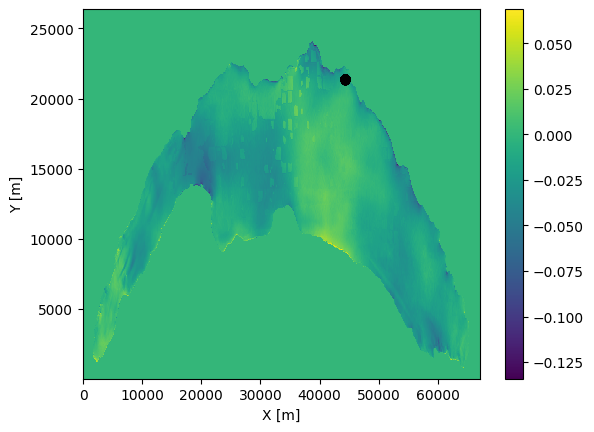

In [57]:
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, 0, :-1, :-1])
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

## Set output parameters

In [58]:
output_file = pset.ParticleFile(
    name="EddyParticles.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

## Run simulation

In [61]:
start_clock = time.time()
pset.execute(
    parcels.AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=1),  # the total length of the run
    dt=timedelta(minutes=60),  # the timestep of the kernel
    output_file=output_file,
)
end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

INFO: Output files are stored in EddyParticles.zarr.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400.0/86400.0 [00:00<00:00, 152853.00it/s]
Done. Operation took 2.722728729248047s.
